# Processing

Импорт и парсинг CSV

In [16]:
from pathlib import Path
from scripts.utils import parse_hgvs_file

input_csv = Path('/home/nikolenko/work/mipt/EvolvePro/data/dms/activity/ube2i.csv')
output_file = parse_hgvs_file(input_csv)

Save to /home/nikolenko/work/mipt/EvolvePro/data/dms/activity/ube2i_parsed.csv


Обработка датасета 

Cutoff values: [0.3]
Number above cutoff: [1643]
Fractions above cutoff: [0.543859649122807]
Process dataset done! [0.543859649122807]


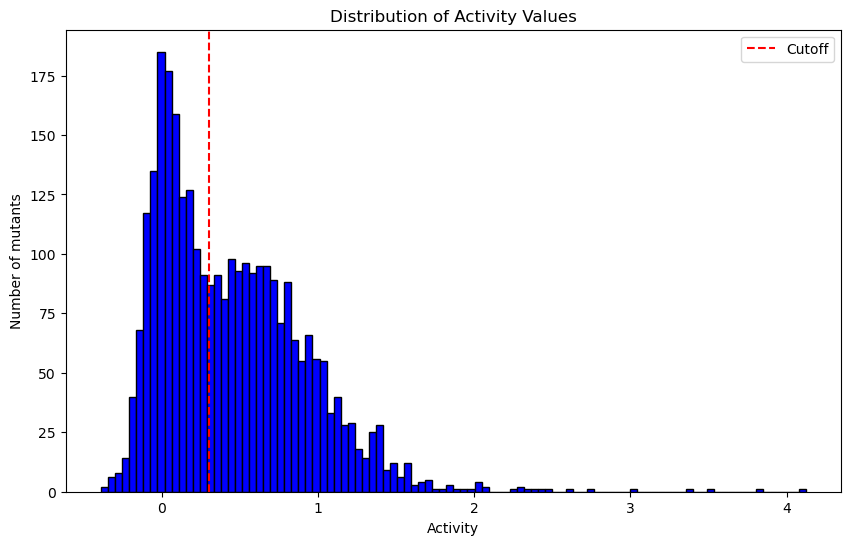

In [17]:
from evolvepro.src.process import process_dataset
import matplotlib.pyplot as plt

parsed_csv = '/home/nikolenko/work/mipt/EvolvePro/data/dms/activity/ube2i_parsed.csv'
wt_fasta = '/home/nikolenko/work/mipt/EvolvePro/data/dms/wt_fasta/ube2i_WT.fasta'
out_dir = '/home/nikolenko/work/mipt/EvolvePro/data/output/ube2i'

df, frac = process_dataset(
    file_path=parsed_csv,          
    dataset_name='ube2i',          
    wt_fasta_path=wt_fasta,       
    activity_column='Activity',    
    cutoff_value=0.3,
    output_dir=out_dir,
    sheet_name=None,
    cutoff_rule='greater_than',
    drop_columns=False
)

print("Process dataset done!", frac)



plt.figure(figsize=(10, 6))
plt.hist(df['Activity'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Activity')
plt.ylabel('Number of mutants')
plt.title('Distribution of Activity Values')
plt.axvline(x=0.3, color='red', linestyle='--', label='Cutoff')
plt.legend()
plt.show()


In [18]:
import pandas as pd
from pathlib import Path
from scripts.utils import read_fasta_as_dict

csv_path = Path("/home/nikolenko/work/mipt/EvolvePro/data/output/ube2i/ube2i_labels.csv")
fasta_path = Path("/home/nikolenko/work/mipt/EvolvePro/data/output/ube2i/ube2i.fasta")

df_labels = pd.read_csv(csv_path)

variant2seq = read_fasta_as_dict(fasta_path)

df_labels["full_seq"] = df_labels["variant"].map(variant2seq)
df_labels.dropna(subset=["full_seq"], inplace=True)

print(len(variant2seq), "mutant sequences read from fasta.")
display(df_labels.head(3))

3021 mutant sequences read from fasta.


,Position,WT_Residue,Mut_Residue,Activity,variant,activity,activity_scaled,activity_binary,full_seq
0,73,P,Q,-0.026176,P73Q,-0.026176,0.080156,0,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
1,137,Y,V,-0.115652,Y137V,-0.115652,0.060317,0,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
2,27,V,D,-0.063647,V27D,-0.063647,0.071848,0,MSGIALSRLAQERKAWRKDHPFGFVADPTKNPDGTMNLMNWECAIP...


# Считаем log-likelihood

In [19]:
"""
!CUDA_VISIBLE_DEVICES=6 ~/miniforge/envs/plm/bin/python ../evolvepro/plm/esm/calc_likelihood.py \

  esm2_t36_3B_UR50D ../data/output/ube2i/ube2i.fasta ../data/output/ube2i/likelihood_scores.csv \
  --toks_per_batch 8
"""

'\n!CUDA_VISIBLE_DEVICES=6 ~/miniforge/envs/plm/bin/python ../evolvepro/plm/esm/calc_likelihood.py \n  esm2_t36_3B_UR50D ../data/output/ube2i/ube2i.fasta ../data/output/ube2i/likelihood_scores.csv   --toks_per_batch 8\n'

In [20]:
import pandas as pd
df_ll = pd.read_csv("../data/output/ube2i/likelihood_scores.csv") 

min_val = df_ll["log_likelihood"].min()
max_val = df_ll["log_likelihood"].max()

df_ll["log_likelihood_scaled"] = (
    (df_ll["log_likelihood"] - min_val)
    / (max_val - min_val)
)

df_merge = pd.merge(df_labels, df_ll, left_on="variant", right_on="name")
df_merge 

,Position,WT_Residue,Mut_Residue,Activity,variant,activity,activity_scaled,activity_binary,full_seq,name,sequence,log_likelihood,log_likelihood_scaled
0,73,P,Q,-0.026176,P73Q,-0.026176,0.080156,0,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,P73Q,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,-36.984851,0.370926
1,137,Y,V,-0.115652,Y137V,-0.115652,0.060317,0,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,Y137V,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,-32.637144,0.623725
2,27,V,D,-0.063647,V27D,-0.063647,0.071848,0,MSGIALSRLAQERKAWRKDHPFGFVADPTKNPDGTMNLMNWECAIP...,V27D,MSGIALSRLAQERKAWRKDHPFGFVADPTKNPDGTMNLMNWECAIP...,-28.380113,0.871252
3,14,K,S,0.104183,K14S,0.104183,0.109060,0,MSGIALSRLAQERSAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,K14S,MSGIALSRLAQERSAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,-28.766728,0.848772
4,73,P,C,0.623095,P73C,0.623095,0.224117,1,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,P73C,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,-32.857465,0.610914
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,77,F,P,-0.035700,F77P,-0.035700,0.078044,0,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,F77P,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,-33.678633,0.563167
3017,72,P,Q,0.506088,P72Q,0.506088,0.198173,1,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,P72Q,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,-31.952468,0.663536
3018,62,M,C,0.377367,M62C,0.377367,0.169632,1,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,M62C,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,-31.606155,0.683672
3019,148,V,A,0.510032,V148A,0.510032,0.199048,1,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,V148A,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,-28.176743,0.883077


In [21]:
import numpy as np
from sklearn.linear_model import Ridge

AA_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"

def one_hot(seq: str) -> np.ndarray:
    L = len(seq)
    arr = np.zeros(L * len(AA_ALPHABET), dtype=np.float32)
    for i, aa in enumerate(seq):
        idx = AA_ALPHABET.find(aa)
        if idx != -1:
            arr[i * len(AA_ALPHABET) + idx] = 1.0
    return arr

X_list, y_list = [], []

for i, row in df_merge.iterrows():
    seq = row["sequence"]
    y   = row["activity"]
    llv = row["log_likelihood_scaled"]  # или row["log_likelihood"]
    
    oh_vec = one_hot(seq)
    feats  = np.concatenate([oh_vec, [llv]])
    X_list.append(feats)
    y_list.append(y)

X = np.vstack(X_list)
y = np.array(y_list)

model = Ridge(alpha=1.0)
model.fit(X, y)

print("R^2 on entire set =", model.score(X,y))


preds = model.predict(X)  # shape (N,)

df_merge["onehot_ll_pred"] = preds


df_merge = df_merge.sort_values(by="onehot_ll_pred", ascending=False)


top_variants = df_merge.head(16)["variant"].tolist()
print("Top variants =", top_variants)
print(len(top_variants))

top_variants = df_merge.head(16)["variant"].tolist()

top_variants = [v for v in top_variants if v != "WT"]

df_merge.to_csv("../data/output/ube2i/ube2i_labels.csv", index=False)

R^2 on entire set = 0.873240696509073
Top variants = ['T91C', 'E98S', 'L97C', 'A5H', 'E98N', 'L97T', 'E98D', 'E98Y', 'D100S', 'E98A', 'E98I', 'S89H', 'D100M', 'E98G', 'T91G', 'C75I']
16


# Считаем ESM embeddings

In [22]:
## !CUDA_VISIBLE_DEVICES=6 ~/miniforge/envs/plm/bin/python evolvepro/plm/esm/extract.py esm2_t36_3B_UR50D data/output/ube2i/ube2i.fasta data/output/ube2i/embeddings/markin_esm2_t36_3B_UR50D --toks_per_batch 3 --include mean --concatenate_dir data/output/ube2i/embeddings


In [23]:
import pandas as pd

df_labels = pd.read_csv("../data/output/ube2i/ube2i_labels.csv")

df_embeddings = pd.read_csv("../data/output/ube2i/embeddings/ube2i_esm2_t36_3B_UR50D.csv", index_col=0)

common_variants = set(df_labels['variant']).intersection(df_embeddings.index)
df_labels = df_labels[df_labels['variant'].isin(common_variants)].copy()
df_embeddings = df_embeddings.loc[list(common_variants)].copy()

df_labels = df_labels.sort_values(by="variant").reset_index(drop=True)
df_embeddings = df_embeddings.loc[df_labels["variant"]]

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
import pandas as pd
df = pd.read_csv("../data/output/ube2i/embeddings/ube2i_onehot_ll_features.csv")
df

,T91C,0.0,0.0.1,0.0.2,0.0.3,0.0.4,0.0.5,0.0.6,0.0.7,0.0.8,...,0.0.3013,0.0.3014,0.0.3015,0.0.3016,0.0.3017,0.0.3018,0.0.3019,0.0.3020,1.0.158,0.6677729070377013
0,E98S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.982040
1,L97C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.526947
2,A5H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.730522
3,E98N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.992376
4,L97T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.830424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,R13P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.235582
3016,A129W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.371998
3017,F77Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.213195
3018,F77D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.194764


In [11]:
latent_df = pd.DataFrame(X, columns=[f"latent_{i}" for i in range(X.shape[1])])
latent_df.insert(0, "", df_merge["variant"].values)

latent_df.to_csv("../data/output/ube2i/embeddings/ube2i_likelihood.csv", index=False)


In [ ]:
from scripts.dms.dms_main import grid_search

grid_search(
    dataset_name='ube2i',
    experiment_name='likelihood',
    model_name='likelihood',
    embeddings_path='../data/output/ube2i/embeddings',
    labels_path='../data/output/ube2i',
    num_simulations=3,
    num_iterations=[10],
    measured_var=['activity'],
    learning_strategies=['topn'],
    num_mutants_per_round=[16],
    num_final_round_mutants=16,
    first_round_strategies=['random'],
    embedding_types=['embeddings'],
    pca_components=None,
    regression_types=['randomforest'],
    embeddings_file_type='csv',
    output_dir='../data/output/ube2i/dms_results_ube2i',
    embeddings_type_pt=None,
)

Embeddings and labels are aligned
Total combinations: 1
Starting labels length: 3021
Starting non-wt length: 3021
iterations considered:    variant  iteration
0      M1L          0
1    L113K          0
2    N121W          0
3    R149V          0
4    N121H          0
5    D100N          0
6     K76R          0
7     P69T          0
8     S71K          0
9     F77T          0
10   A129K          0
11    N31I          0
12    F24M          0
13    E98Q          0
14     G3A          0
15    F82R          0
16      WT          0
(3005,)
iterations considered:    variant  iteration
0     T51I          1
1    I107V          1
2     N85P          1
3    T135Y          1
4    K101C          1
5    L113A          1
6    W103M          1
7      S7H          1
8      S7C          1
9     K48R          1
10    C43H          1
11   P157Q          1
12    W41D          1
13    F64C          1
14    N31Y          1
15    G55L          1
16     M1L          0
17   L113K          0
18   N121W        

In [19]:
from scripts.dms.dms_main import grid_search

# Random
grid_search(
    dataset_name='ube2i',
    experiment_name='random_start_ube2i',
    model_name='esm2_t36_3B_UR50D',
    embeddings_path='data/output/ube2i/embeddings',
    labels_path='data/output/ube2i',
    num_simulations=3,
    num_iterations=[10],
    measured_var=['activity'],
    learning_strategies=['topn'],
    num_mutants_per_round=[16],
    num_final_round_mutants=16,
    first_round_strategies=['random'],
    embedding_types=['embeddings'],
    pca_components=None,
    regression_types=['randomforest'],
    embeddings_file_type='csv',
    output_dir='data/output/ube2i/dms_results_ube2i',
    embeddings_type_pt=None,
)

Embeddings and labels are aligned
Total combinations: 1
Starting labels length: 3021
Starting non-wt length: 3021
iterations considered    variant  iteration
0      M1L          0
1    L113K          0
2    N121W          0
3    R149V          0
4    N121H          0
5    D100N          0
6     K76R          0
7     P69T          0
8     S71K          0
9     F77T          0
10   A129K          0
11    N31I          0
12    F24M          0
13    E98Q          0
14     G3A          0
15    F82R          0
16      WT          0
(3005,)
iterations considered    variant  iteration
0    D100S          1
1    D100C          1
2    D100Q          1
3    D100A          1
4    D100I          1
5    D100M          1
6    D102C          1
7    D100T          1
8    D100V          1
9      S2G          1
10   D100L          1
11     I4W          1
12   D102R          1
13   D100F          1
14    D66E          1
15   D100H          1
16     M1L          0
17   L113K          0
18   N121W          

Saved figure: ../data/output/ube2i/dms_plots_ube2i/ube2i_compare_activity_binary.png
Saved figure: ../data/output/ube2i/dms_plots_ube2i/ube2i_compare_median_activity.png
Saved figure: ../data/output/ube2i/dms_plots_ube2i/ube2i_compare_top_activity.png


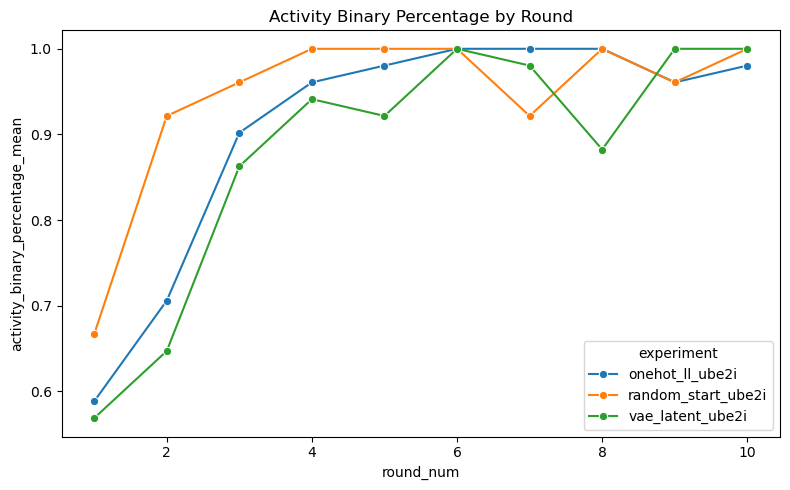

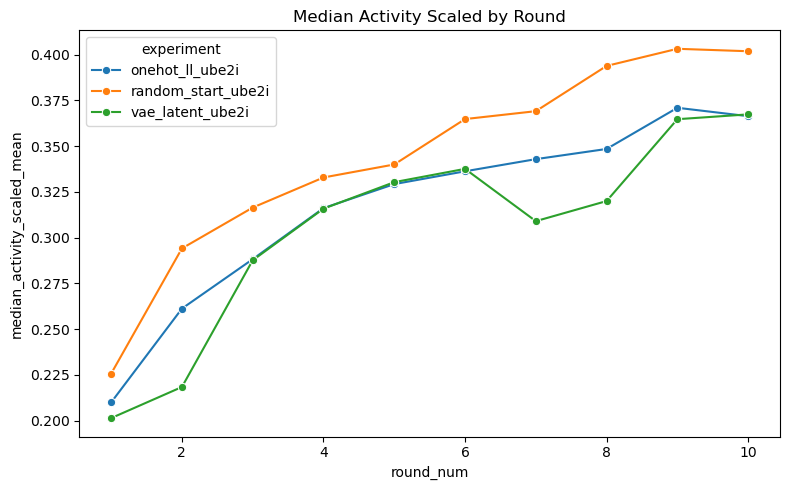

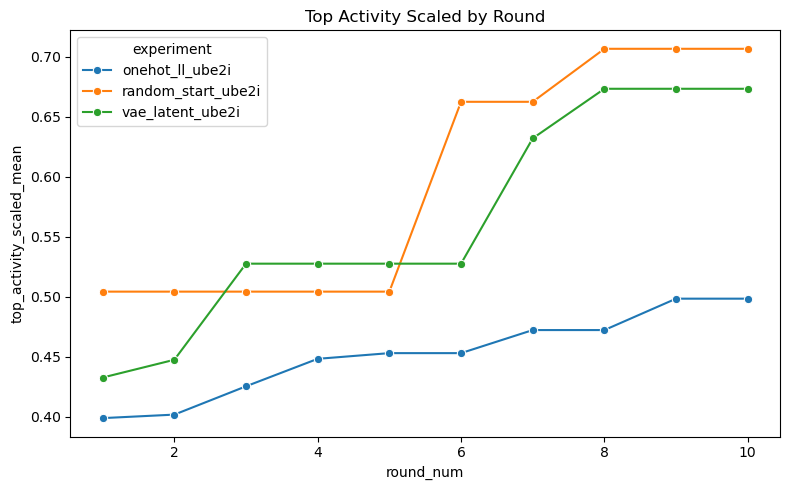

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_experiment_csv(file_path, dataset_name, experiment_name):
    df = pd.read_csv(file_path)
    df["dataset"] = dataset_name
    df["experiment"] = experiment_name
    return df

def aggregate_by_experiment_and_round(df, group_cols=("experiment", "round_num"), agg_cols=("activity_binary_percentage", "median_activity_scaled", "top_activity_scaled")):
    df = df.replace("None", pd.NA)
    for col in agg_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    grouped = df.groupby(list(group_cols))[list(agg_cols)].mean()
    df_agg = grouped.reset_index()
    df_agg.rename(columns={"activity_binary_percentage": "activity_binary_percentage_mean", "median_activity_scaled": "median_activity_scaled_mean", "top_activity_scaled": "top_activity_scaled_mean"}, inplace=True)
    return df_agg

def plot_line_by_round(df, x_col, y_col, hue_col="experiment", title="", output_dir=".", output_file=""):
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x=x_col, y=y_col, hue=hue_col, marker="o")
    plt.title(title)
    plt.tight_layout()
    if output_file:
        os.makedirs(output_dir, exist_ok=True)
        save_path = os.path.join(output_dir, output_file)
        plt.savefig(save_path, dpi=300)
        print(f"Saved figure: {save_path}")
    else:
        plt.show()

def main():
    data_dir = "../data/output/ube2i/dms_results_ube2i"
    output_dir = "../data/output/ube2i/dms_plots_ube2i"
    csv_onehot = os.path.join(data_dir, "ube2i_likelihood_likelihood.csv")
    csv_random = os.path.join(data_dir, "ube2i_esm2_t36_3B_UR50D_random_start_ube2i.csv")
    csv_vae = os.path.join(data_dir, "ube2i_vae_latent_vae_latent.csv")
    df_onehot = load_experiment_csv(csv_onehot, "ube2i", "onehot_ll_ube2i")
    df_random = load_experiment_csv(csv_random, "ube2i", "random_start_ube2i")
    df_vae = load_experiment_csv(csv_vae, "ube2i", "vae_latent_ube2i")
    df_all = pd.concat([df_onehot, df_random, df_vae], ignore_index=True)
    df_agg = aggregate_by_experiment_and_round(df_all)
    plot_line_by_round(df_agg, "round_num", "activity_binary_percentage_mean", "experiment", "Activity Binary Percentage by Round", output_dir, "ube2i_compare_activity_binary.png")
    plot_line_by_round(df_agg, "round_num", "median_activity_scaled_mean", "experiment", "Median Activity Scaled by Round", output_dir, "ube2i_compare_median_activity.png")
    plot_line_by_round(df_agg, "round_num", "top_activity_scaled_mean", "experiment", "Top Activity Scaled by Round", output_dir, "ube2i_compare_top_activity.png")

if __name__ == "__main__":
    main()
